In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [3]:
import prince_cr.config
from prince_cr import core, util, photonfields, cross_sections
from prince_cr import util as pru

# Setup PrinceRun object

Before you create the kernel, you can change options in the config.  
See `prince/config.py` for a full list of options

In [4]:
prince_cr.config.x_cut = 1e-4
prince_cr.config.x_cut_proton = 1e-2
prince_cr.config.tau_dec_threshold = np.inf

### Now create the objects:
- Photonfield class
- Cross section class
- PriNCe core class, that will contain the cross section kernel

(The latter two take some time)

Note that TabulatedCrossSection will look for data in the database stored in `./prince/data/prince_db_05`

#### Photon field class

This is a combined photon field of CMB and Gilmore et al. EBL  
See classes in `prince/photonfields.py` for different options

In [5]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])

CPU times: user 0 ns, sys: 1.56 ms, total: 1.56 ms
Wall time: 2.59 ms


#### Cross section class

This is a combined cross section of `Talys` as low energy the `Sophia` superposition model at high energies
See classes in `prince/cross_sections.py` for different options

In [6]:
cs = cross_sections.CompositeCrossSection(
    [
        (0.0, cross_sections.TabulatedCrossSection, ("PSB",)),
        (0.14, cross_sections.SophiaSuperposition, ()),
    ]
)

CompositeCrossSection::_join_models(): Attempt to join 2 models.


#### Prince_run kernel

The `inclusive interpolator not found` warnings can be ignored. They tell that in the final state of the first tuple member are no secondaries of the same mass. This can be understood as an elastic process.

In [7]:
%%time
prince_run_talys = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5626), np.int32(5626))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5525), np.int32(5525))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5424), np.int32(5424))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5324), np.int32(5324))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5224), np.int32(5224))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5123), np.int32(5123))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(5023), np.int32(5023))
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (np.int32(4922), np.int32(4922))
PhotoNuclearInte

# Run a solver using the loaded kernel

**Note:** We use a backward differentiation solver (BDF) here (`UHECRPropagationSolverBDF`)  
There are other options in `prince/solvers`, however these are not robustly tested.  
**So when in doubt use BDF**

In [8]:
from prince_cr.solvers import UHECRPropagationSolverBDF
from prince_cr.cr_sources import AugerFitSource, RigdityCutoffSource

**Step 1:** Initiate solver class

In [16]:
solver = UHECRPropagationSolverBDF(
    initial_z=1.0,
    final_z=0.0,
    prince_run=prince_run_talys,
    enable_pairprod_losses=True,
    enable_adiabatic_losses=True,
    enable_injection_jacobian=True,
    enable_partial_diff_jacobian=True,
)

**Step 2:** Create a source class and add it to the solver

**Note:** There are more source classes defined in `prince/sources.py`

In [17]:
rmax = 10**9.68
gamma = 0.96
total_norm = 1e-50

f_hydrogen = 0.0
f_helium = 67.3
f_nitrogen = 28.1
f_silicon = 4.6
f_iron = 0.0

# NOTE: You can add as much as you want here.
# you can also add several source classes. But that will be slower, if there are many
solver.add_source_class(
    AugerFitSource(
        prince_run_talys,
        norm=total_norm,
        params={
            101: (gamma, rmax, f_hydrogen),
            402: (gamma, rmax, f_helium),
            1407: (gamma, rmax, f_nitrogen),
            2814: (gamma, rmax, f_silicon),
            5626: (gamma, rmax, f_iron),
        },
    )
)

**Note:** We add here only one source, but one could in principle add any number of sources here  
(For a large number of different source classes, the solver will get slow)

**Step 3:** Run the solver

In [18]:
%time solver.solve(dz=1e-3,verbose=False,progressbar=True)

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

# Now plot the result

To compare the results to data one has to obtain the 
[*prince_analysis_tools*](https://github.com/joheinze/PriNCe-analysis-tools) package and
add it to the `PYTHONPATH` as shown below.

In [12]:
# import sys
# sys.path.append('../../PriNCe-analysis-tools/')

In [13]:
from prince_analysis_tools.spectra import auger2015, auger2017

data = auger2017
data_label = "Auger 2017"

First normalize roughly to the spectrum

In [14]:
result = solver.res

edata = auger2015["energy"]
norm = auger2015["spectrum"][17] / result.get_solution_group("CR", egrid=edata)[1][17]
print(f"{norm:.2e}")

result = result * norm

2.12e+04


### Plot the spectrum

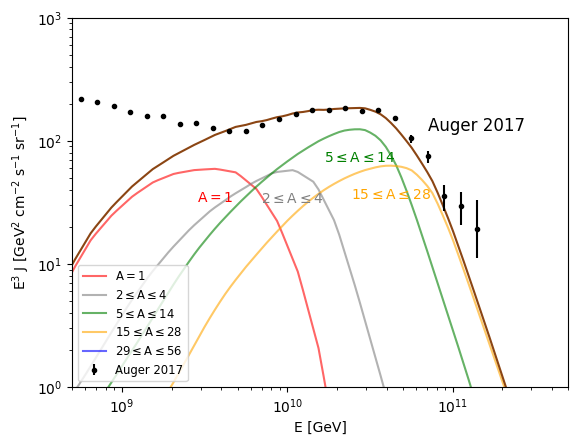

In [15]:
import matplotlib.pyplot as plt

ncoid2sref = result.spec_man.ncoid2sref
A = lambda x: ncoid2sref[x].A

for group, color, label, loffset in zip(
    [(A, 1, 1), (A, 2, 4), (A, 5, 14), (A, 15, 28), (A, 29, 56)],
    ["red", "gray", "green", "orange", "blue"],
    [
        r"$\mathrm{A} = 1$",
        r"$2 \leq \mathrm{A} \leq 4$",
        r"$5 \leq \mathrm{A} \leq 14$",
        r"$15 \leq \mathrm{A} \leq 28$",
        r"$29 \leq \mathrm{A} \leq 56$",
    ],
    [0, 0, 0, 0, 0],
):

    energy, spectrum = result.get_solution_group(group)
    l = plt.loglog(energy, spectrum, label=label, c=color, alpha=0.6)
    maxidx = spectrum.argmax()
    loc = (energy[maxidx + loffset], spectrum[maxidx + loffset] / 1.5)

    # only plot annotations, if they are roughly within plot range
    # otherwise there are clipping errors
    if 5e8 < loc[0] < 5e11 and 1e0 < loc[1] < 1e3:
        plt.annotate(
            label,
            loc,
            color=color,
            weight="bold",
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
        )

energy, spectrum = result.get_solution_group("CR")
l = plt.loglog(energy, spectrum, c="saddlebrown")

plt.errorbar(
    data["energy"],
    data["spectrum"],
    yerr=(data["lower_err"], data["upper_err"]),
    fmt="o",
    color="black",
    label=data_label,
    markersize=3,
)
plt.annotate(
    data_label,
    (data["energy"][-4], data["spectrum"][-4] * 1.5),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="bottom",
)
plt.legend(ncol=1, loc='lower left', fontsize='small')

plt.xlim(5e8, 5e11)
plt.ylim(1e0, 1e3)

plt.ylabel(r"E$^3$ J [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.xlabel(r"E [GeV]")

plt.show()